In [195]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import datetime as dt
%matplotlib inline

In [196]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    ptwt = [np.asarray(p) for p in portfolios]
    
    return np.asarray(wt), returns, risks, ptwt

In [197]:
symbols = ['FB','AMD','AAPL','JBL','TSM']
end = dt.date.today()
start = end - dt.timedelta(days = 365)
stocks = web.get_data_yahoo(symbols, start, end)
adjc = stocks['Adj Close']
print(adjc.head(),end,start)

Symbols             FB        AMD        AAPL        JBL         TSM
Date                                                                
2021-01-15  251.360001  88.209999  126.361000  44.335274  123.264885
2021-01-19  261.100006  89.449997  127.046791  44.872074  129.239624
2021-01-20  267.480011  88.750000  131.221039  45.239876  128.589996
2021-01-21  272.869995  91.529999  136.031403  45.319401  132.054764
2021-01-22  274.500000  92.790001  138.217926  44.951599  127.113533 2022-01-15 2021-01-15


102.86118575989494


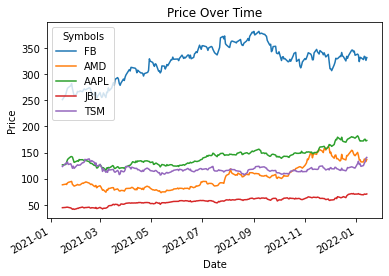

In [198]:
adjc.plot()
plt.title('Price Over Time')
plt.ylabel('Price')
plt.xlabel('Date')
print(adjc['AMD'].mean())

Text(0.5, 1.0, 'TSM Simple Returns')

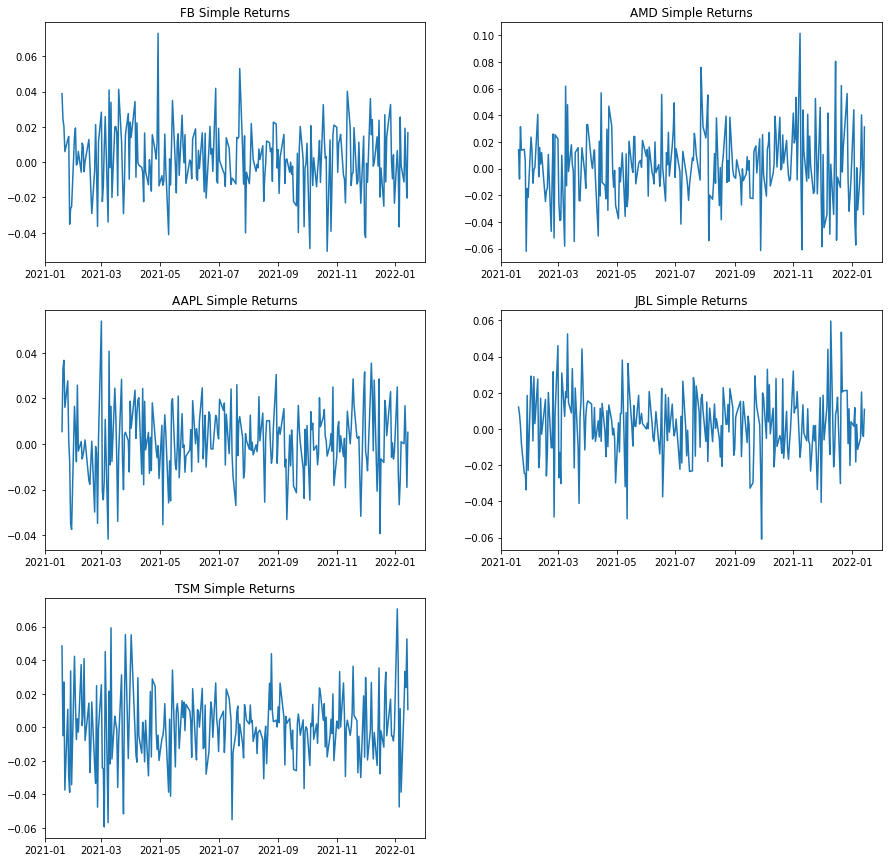

In [199]:
sror = adjc.pct_change()

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)


ax1.plot(sror['FB'])
ax1.set_title('FB Simple Returns')
ax2.plot(sror['AMD'])
ax2.set_title('AMD Simple Returns')
ax3.plot(sror['AAPL'])
ax3.set_title('AAPL Simple Returns')
ax4.plot(sror['JBL'])
ax4.set_title('JBL Simple Returns')
ax5.plot(sror['TSM'])
ax5.set_title('TSM Simple Returns')

In [200]:
#mean variance portfolio optimization
selected = list(adjc)

daily_ret = adjc[selected].pct_change()
expected_ret = daily_ret.mean()
daily_cov = daily_ret.cov()

df = return_portfolios(expected_ret, daily_cov)
df = df.iloc[1:,:]

weights, returns, risks, ptwt = optimal_portfolio(daily_ret[1:])



     pcost       dcost       gap    pres   dres
 0: -1.4945e-03 -1.0021e+00  1e+00  2e-16  3e+00
 1: -1.4950e-03 -1.2087e-02  1e-02  5e-17  3e-02
 2: -1.5396e-03 -2.1866e-03  6e-04  7e-17  2e-03
 3: -2.0501e-03 -2.2468e-03  2e-04  2e-16  2e-04
 4: -2.0655e-03 -2.0753e-03  1e-05  1e-16  1e-05
 5: -2.0721e-03 -2.0727e-03  6e-07  2e-16  2e-08
 6: -2.0727e-03 -2.0727e-03  6e-09  1e-16  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4931e-03 -1.0021e+00  1e+00  1e-16  3e+00
 1: -1.4936e-03 -1.2085e-02  1e-02  1e-16  3e-02
 2: -1.5381e-03 -2.1838e-03  6e-04  6e-17  2e-03
 3: -2.0469e-03 -2.2412e-03  2e-04  1e-15  2e-04
 4: -2.0616e-03 -2.0711e-03  9e-06  2e-16  9e-06
 5: -2.0675e-03 -2.0682e-03  7e-07  2e-16  2e-08
 6: -2.0682e-03 -2.0682e-03  1e-08  2e-18  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4915e-03 -1.0021e+00  1e+00  4e-16  3e+00
 1: -1.4920e-03 -1.2082e-02  1e-02  1e-16  3e-02
 2: -1.5365e-03 -2.1807e

Weights in order of call:  [[3.09268048e-07]
 [9.99656731e-01]
 [3.50662866e-07]
 [3.42418784e-04]
 [1.90235886e-07]] 
Returns:  0.0021093961474122347 
Risk:  0.027104672957424872 
 [[4.74106219e-08]
 [9.99991172e-01]
 [3.73390674e-08]
 [8.66835944e-06]
 [7.52349367e-08]]


Text(0.5, 1.0, 'Efficient Frontier')

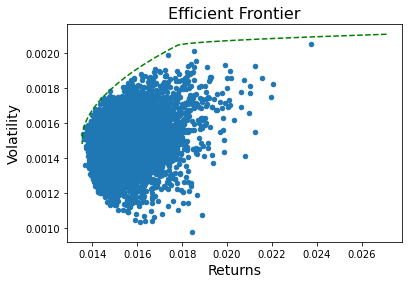

In [201]:
pt = 1
print('Weights in order of call: ',ptwt[pt],'\nReturns: ', returns[pt],'\nRisk: ', risks[pt], '\n', weights)
df.plot.scatter(x = 'Volatility', y = 'Returns')
plt.plot(risks,returns,"g--")
plt.xlabel('Returns', fontsize = 14)
plt.ylabel('Volatility', fontsize = 14)
plt.title('Efficient Frontier', fontsize = 16)

In [202]:
print(ptwt)

[array([[2.60393805e-07],
       [9.99831557e-01],
       [2.94624103e-07],
       [1.67726557e-04],
       [1.61040200e-07]]), array([[3.09268048e-07],
       [9.99656731e-01],
       [3.50662866e-07],
       [3.42418784e-04],
       [1.90235886e-07]]), array([[4.10073659e-07],
       [9.98962885e-01],
       [4.71077410e-07],
       [1.03599444e-03],
       [2.39669645e-07]]), array([[1.96562408e-06],
       [9.93713078e-01],
       [2.25899217e-06],
       [6.28154873e-03],
       [1.14819009e-06]]), array([[4.33626434e-07],
       [9.92169600e-01],
       [4.99057244e-07],
       [7.82921487e-03],
       [2.52365467e-07]]), array([[1.92823085e-06],
       [9.17098999e-01],
       [2.22254289e-06],
       [8.28957328e-02],
       [1.11717343e-06]]), array([[2.01178325e-07],
       [8.44875107e-01],
       [2.29596303e-07],
       [1.55124339e-01],
       [1.22742853e-07]]), array([[6.92364447e-08],
       [7.75279374e-01],
       [7.31579986e-08],
       [2.24720426e-01],
       [5.